In [59]:
from itertools import islice, permutations, product
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from magnolia.features.mixer import FeatureMixer
#from magnolia.features.wav_iterator import batcher
from magnolia.utils.tf_bits import scope
from magnolia.utils.bss_eval import bss_eval_sources
from magnolia.factorization.nmf import snmf
from magnolia.features.spectral_features import reconstruct

num_srcs = 2
num_steps = 51
num_freq_bins = 257
batch_size = 64
n_comps=5

librispeech_dev = "/local_data/teams/magnolia/librispeech/processed_dev-clean.h5"
librispeech_train = "/local_data/teams/magnolia/librispeech/processed_train-clean-100.h5"

def scale_spectrogram(spectrogram):
    mag_spec = np.abs(spectrogram)
    phases = np.unwrap(np.angle(spectrogram))
    
    mag_spec = np.sqrt(mag_spec)
    M = mag_spec.max()
    m = mag_spec.min()
    
    return (mag_spec - m)/(M - m), phases

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


mixed_features = FeatureMixer([librispeech_dev, librispeech_dev], shape=(num_steps, None))

%matplotlib inline

In [56]:
a_c,b_c,c_c = next(mixed_features)
a,b,c = [scale_spectrogram(x)[0] for x in (a_c,b_c,c_c)]

/opt/conda/envs/magnolia3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/magnolia3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/conda/envs/magnolia3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


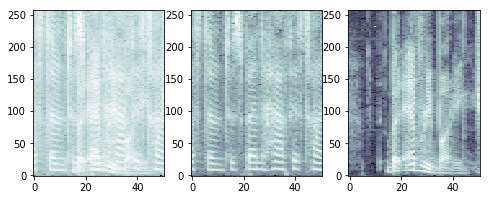

In [60]:
plt.figure(figsize=(8,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(a.T)), cmap='bone', origin='lower', aspect=1/4)
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(b.T)), cmap='bone', origin='lower', aspect=1/4)
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(c.T)), cmap='bone', origin='lower', aspect=1/4)

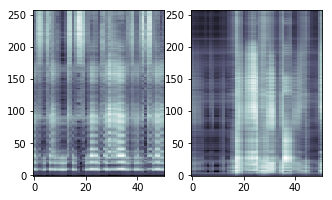

In [61]:
# Deconstruct speaker-specific sources
mag_b = np.abs(b)
b_w, b_h = snmf(mag_b, n_comps)
recon_b = b_w @ b_h

mag_c = np.abs(c)
c_w, c_h = snmf(mag_c, n_comps)
recon_c = c_w @ c_h

plt.figure(figsize=(8,7))
plt.subplot(1,3,1)
plt.imshow(np.log(recon_b.T), cmap='bone', origin='lower', aspect=1/4)
plt.subplot(1,3,2)
plt.imshow(np.log(recon_c.T), cmap='bone', origin='lower', aspect=1/4)

In [62]:
mag_a = np.abs(a)
mix_dictionary = np.concatenate((b_w, c_w), axis=1)
_, a_h = snmf(mag_a, n_comps*2, W=mix_dictionary)

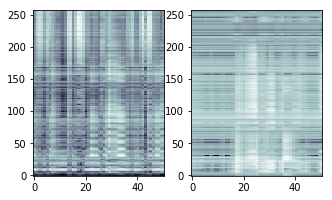

In [65]:
sep_b = mix_dictionary[:,:n_comps] @ a_h[:n_comps]
sep_c = mix_dictionary[:,n_comps:] @ a_h[n_comps:]
plt.figure(figsize=(8,7))
plt.subplot(1,3,1)
plt.imshow(np.log(sep_b.T), cmap='bone', origin='lower', aspect=1/4)
plt.subplot(1,3,2)
plt.imshow(np.log(sep_c.T), cmap='bone', origin='lower', aspect=1/4)

In [66]:
display.display(display.Audio(reconstruct(a, a_c, 10000, 0.0512, 0.0256), rate=10000))

Size of reconstruction (12800) does not match value of deprecated recon_size parameter (1.3312).


In [67]:
display.display(display.Audio(reconstruct(b, b_c, 10000, 0.0512, 0.0256), rate=10000))
display.display(display.Audio(reconstruct(sep_b, a_c, 10000, 0.0512, 0.0256), rate=10000))

Size of reconstruction (12800) does not match value of deprecated recon_size parameter (1.3312).


Size of reconstruction (12800) does not match value of deprecated recon_size parameter (1.3312).


In [68]:
display.display(display.Audio(reconstruct(c, c_c, 10000, 0.0512, 0.0256), rate=10000))
display.display(display.Audio(reconstruct(sep_c, a_c, 10000, 0.0512, 0.0256), rate=10000))

Size of reconstruction (12800) does not match value of deprecated recon_size parameter (1.3312).


Size of reconstruction (12800) does not match value of deprecated recon_size parameter (1.3312).
